<a href="https://colab.research.google.com/github/GC-on-git/Others/blob/main/OpticalQ2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OPTICAL ASSIGNMENT
ANURAG GC, 121EC0267

# Importing Packages

`random`: Used to generate random connections and datarates.

`networkx`: For creating and managing the network graph.

`matplotlib.pyplot`: To plot results.

`itertools.islice`: To retrieve the first k paths efficiently.

In [ ]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from itertools import islice

# Defining parameters

In [ ]:
NUM_NODES = 8
INITIAL_CONNECTIONS = 15
DATARATE_RANGE = (50, 500)  # in Gbps
NUM_SLOTS = 100  # Total slots per link
SLOT_SIZE = 50  # Each slot supports 50 Gbps
K = 2  # Number of shortest paths to consider

# Creation of mesh topology

Creating a graph G with `num_nodes` nodes.

The function randomly adds edges between nodes until the number of edges equals `num_connections`.

Each edge has:
`datarate`: Random value in the given range.

`slots`: A list of 100 elements initialized to 0 (indicating all slots are free).

In [ ]:
def generate_mesh_topology(num_nodes, num_connections):
    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i)
    while G.number_of_edges() < num_connections:
        u, v = random.sample(range(num_nodes), 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v, datarate=random.randint(*DATARATE_RANGE), slots=[0] * NUM_SLOTS)
    return G

# Shortest k paths
Finding the top k shortest paths between `source` and `target` using NetworkX's `shortest_simple_paths` inbuilt function.

`islice` helps to limit the generator output to the first k paths.

In [ ]:
# K-shortest paths generator
def k_shortest_paths(graph, source, target, k):
    return list(islice(nx.shortest_simple_paths(graph, source, target, weight=None), k))

# Slot calculation
Ceiling function is used for slot calculation as partial slot usage also requires a full slot to be allocated.

In [ ]:
# Calculate required frequency slots for a connection
def calculate_slots_required(datarate, slot_size):
    return -(-datarate // slot_size)  # Ceiling division

# RSA
Slots: `slots_needed` computes how many slots are required for the connection.

Paths:`k_shortest_paths` between source and destination.

Slot Availability: `available_slots` are initialised as True for all 100 slots.
For each link in the path, `available_slots` are updated based on whether the slots are free.

Contiguous Slots:Checking for a contiguous block of `slots_needed` free slots in `available_slots`.
If found, those slots are marked as occupied on all links in the path.


If allocation is successful, returns `False` (not blocked).
If no path can allocate the connection, returns `True` (blocked).

In [ ]:
# Perform RSA for a connection
def perform_rsa(graph, source, destination, datarate, k):
    slots_needed = calculate_slots_required(datarate, SLOT_SIZE)
    paths = k_shortest_paths(graph, source, destination, k)
    for path in paths:
        available_slots = [True] * NUM_SLOTS
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
            available_slots = [available_slots[j] and (graph[u][v]['slots'][j] == 0) for j in range(NUM_SLOTS)]
        if any(all(available_slots[i:i + slots_needed]) for i in range(NUM_SLOTS - slots_needed + 1)):
            for i in range(NUM_SLOTS - slots_needed + 1):
                if all(available_slots[i:i + slots_needed]):
                    for j in range(len(path) - 1):
                        u, v = path[j], path[j + 1]
                        graph[u][v]['slots'][i:i + slots_needed] = [1] * slots_needed
                    return False  # Allocation successful
    return True  # Allocation failed

# Simulation
1. Creating a mesh topology with 15 initial connections.
2. Gradually increasing the number of connections from 15 to 35.
3. For each connection, attempting RSA and incrementing blocks if allocation fails.

In [ ]:
# Simulation
def simulate_rsa(G):
    num_blocks = []
    for num_connections in range(INITIAL_CONNECTIONS, INITIAL_CONNECTIONS + 20):  # Increase connections gradually
        blocks = 0
        for _ in range(num_connections):
            source, destination = random.sample(range(NUM_NODES), 2)
            datarate = random.randint(*DATARATE_RANGE)
            if perform_rsa(G, source, destination, datarate, K):
                blocks += 1
        num_blocks.append(blocks)
    return num_blocks

# Plotting

Function to plot mesh topology and final results

In [ ]:
#plot network
def plot_graph(G):
    pos = nx.spring_layout(G)  # Use spring layout for visualization
    plt.figure(figsize=(8, 6))

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', edgecolors='black')
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Add title
    plt.title("Mesh Topology Visualization", fontsize=14)
    plt.axis("off")
    plt.show()

# Plot results
def plot_results(num_blocks):
    plt.plot(range(INITIAL_CONNECTIONS, INITIAL_CONNECTIONS + 20), num_blocks, marker='o')
    plt.xlabel("Number of Connections")
    plt.ylabel("Number of Blocks")
    plt.title("Number of Connections vs Number of Blocks")
    plt.grid()
    plt.show()

# Main Function
Generation and visualisation of mesh topology and printing the results

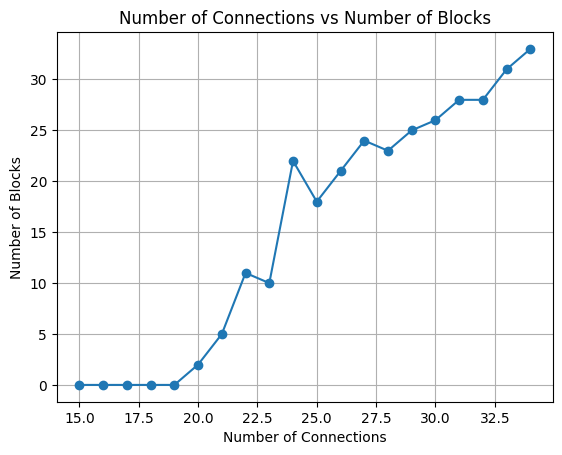

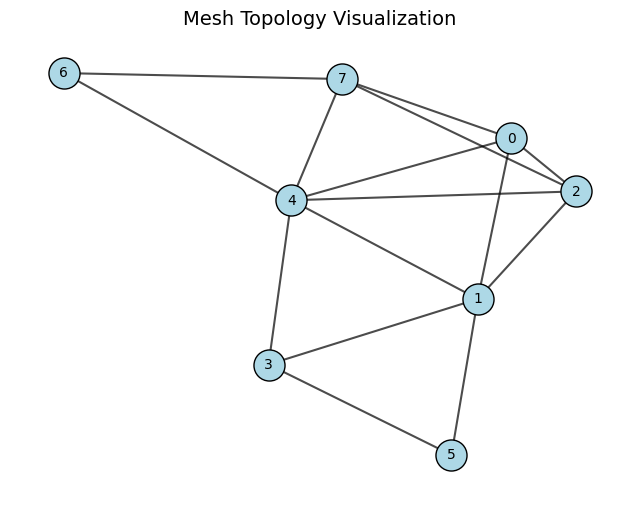

In [ ]:
# Main Execution
G = generate_mesh_topology(NUM_NODES, INITIAL_CONNECTIONS)
num_blocks = simulate_rsa(G)
plot_results(num_blocks)
print("\n\n")
plot_graph(G)